# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [138]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve
from sklearn import metrics
from scipy.stats import ks_2samp

import statsmodels.formula.api as smf

In [62]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [66]:
def bivar_analise(df, resp_var, exp_var):
    tab = pd.crosstab(df[exp_var], df[resp_var], margins=True)
    tab['QMD'] = tab[1]/tab['All']
    tab['Chance'] = tab[1]/tab[0]
    tab['RC_total'] = tab['Chance'] / tab.loc['All', 'Chance']
    tab['Log_chance'] = np.log(tab['Chance'])
    tab['Log_RC'] = np.log(tab['RC_total'])
    return tab

bivar_acucar_sangue = bivar_analise(df, 'flag_doente', 'fbs')
bivar_sexo = bivar_analise(df, 'flag_doente', 'sex')
bivar_angina_sangue = bivar_analise(df, 'flag_doente', 'exang')

In [68]:
bivar_acucar_sangue

flag_doente,0,1,All,QMD,Chance,RC_total,Log_chance,Log_RC
fbs,,,,,,,,
0.0,141,117,258,0.453488,0.829787,0.979030,-0.186586,-0.021193
1.0,23,22,45,0.488889,0.956522,1.128558,-0.044452,0.120941
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [70]:
bivar_sexo

flag_doente,0,1,All,QMD,Chance,RC_total,Log_chance,Log_RC
sex,,,,,,,,
0.0,72,25,97,0.257732,0.347222,0.409672,-1.057790,-0.892398
1.0,92,114,206,0.553398,1.239130,1.461996,0.214410,0.379802
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [72]:
bivar_angina_sangue

flag_doente,0,1,All,QMD,Chance,RC_total,Log_chance,Log_RC
exang,,,,,,,,
0.0,141,63,204,0.308824,0.446809,0.527170,-0.805625,-0.640233
1.0,23,76,99,0.767677,3.304348,3.898655,1.195239,1.360632
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


Oestudo feito com a variavel fbs parece discriminar mais o reisco de doença cardiaca. 

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [74]:
def bivar_analise_quant(df, resp_var, exp_var, num=5):
    df['var_cat'] = pd.qcut(df[exp_var], q=num)
    tab_ = pd.crosstab(df['var_cat'], df[resp_var], margins=True)
    tab_['QMD'] = tab_[1]/tab_['All']
    tab_['Chance'] = tab_[1]/tab_[0]
    tab_['RC_total'] = tab_['Chance'] / tab_.loc['All', 'Chance']
    tab_['Log_chance'] = np.log(tab_['Chance'])
    tab_['Log_RC'] = np.log(tab_['RC_total'])
    tab_['age_mean'] = df['age'].mean()
    return tab_

bivar_idade = bivar_analise_quant(df, 'flag_doente', 'age')
bivar_press_sang = bivar_analise_quant(df, 'flag_doente', 'trestbps')
bivar_colest = bivar_analise_quant(df, 'flag_doente', 'chol', 6)

In [76]:
bivar_idade

flag_doente,0,1,All,QMD,Chance,RC_total,Log_chance,Log_RC,age_mean
var_cat,,,,,,,,,
"(28.999, 45.0]",47,16,63,0.253968,0.340426,0.401653,-1.077559,-0.912166,54.438944
"(45.0, 53.0]",42,22,64,0.343750,0.523810,0.618020,-0.646627,-0.481235,54.438944
"(53.0, 58.0]",32,39,71,0.549296,1.218750,1.437950,0.197826,0.363218,54.438944
"(58.0, 62.0]",13,32,45,0.711111,2.461538,2.904261,0.900787,1.066179,54.438944
"(62.0, 77.0]",30,30,60,0.500000,1.000000,1.179856,0.000000,0.165392,54.438944
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000,54.438944


In [78]:
bivar_press_sang

flag_doente,0,1,All,QMD,Chance,RC_total,Log_chance,Log_RC,age_mean
var_cat,,,,,,,,,
"(93.999, 120.0]",60,37,97,0.381443,0.616667,0.727578,-0.483427,-0.318034,54.438944
"(120.0, 126.0]",10,15,25,0.600000,1.500000,1.769784,0.405465,0.570858,54.438944
"(126.0, 134.0]",35,27,62,0.435484,0.771429,0.910175,-0.259511,-0.094119,54.438944
"(134.0, 144.6]",34,24,58,0.413793,0.705882,0.832840,-0.348307,-0.182914,54.438944
"(144.6, 200.0]",25,36,61,0.590164,1.440000,1.698993,0.364643,0.530036,54.438944
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000,54.438944


In [80]:
bivar_colest

flag_doente,0,1,All,QMD,Chance,RC_total,Log_chance,Log_RC,age_mean
var_cat,,,,,,,,,
"(125.999, 201.0]",32,21,53,0.396226,0.656250,0.774281,-0.421213,-0.255821,54.438944
"(201.0, 222.0]",32,17,49,0.346939,0.531250,0.626799,-0.632523,-0.467130,54.438944
"(222.0, 241.0]",28,22,50,0.440000,0.785714,0.927030,-0.241162,-0.075770,54.438944
"(241.0, 263.333]",26,24,50,0.480000,0.923077,1.089098,-0.080043,0.085350,54.438944
"(263.333, 294.667]",20,30,50,0.600000,1.500000,1.769784,0.405465,0.570858,54.438944
"(294.667, 564.0]",26,25,51,0.490196,0.961538,1.134477,-0.039221,0.126172,54.438944
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000,54.438944


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [82]:
reglog = smf.logit('flag_doente ~ sex + cp + trestbps + age', data=df).fit()
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            4
Date:                Mon, 30 Sep 2024   Pseudo R-squ.:                  0.2605
Time:                        09:02:30   Log-Likelihood:                -154.55
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.264e-22
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.1167      1.608     -6.915      0.000     -14.267      -7.966
sex            1.8021      0.331      5.444      0.000       1.153       2.451
cp             1.1403      0.169      6.739      0.000       0.809       1.472
trestbps       0.0214      0.008      2.600      0.009       0.005       0.037
age            0.0582      0.017      3.348      0.001       0.024       0.092
==============================================================================
"""

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [84]:
df['predito'] = reglog.predict(df)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,var_cat,predito
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,"(222.0, 241.0]",0.196041
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,"(263.333, 294.667]",0.928431
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,"(222.0, 241.0]",0.846558
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,"(241.0, 263.333]",0.276207
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,"(201.0, 222.0]",0.024768


In [90]:
cat_pred = pd.qcut(df['predito'], q=5, duplicates='drop')
cat_pred.value_counts().sort_index()

predito
(0.0119, 0.146]    61
(0.146, 0.349]     60
(0.349, 0.575]     61
(0.575, 0.772]     60
(0.772, 0.928]     61
Name: count, dtype: int64

In [96]:
group_reg = df.groupby(cat_pred)
qualid = group_reg[['flag_doente']].count()
qualid

C:\Users\enzob\AppData\Local\Temp\ipykernel_60428\396474607.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_reg = df.groupby(cat_pred)


,flag_doente
predito,
"(0.0119, 0.146]",61
"(0.146, 0.349]",60
"(0.349, 0.575]",61
"(0.575, 0.772]",60
"(0.772, 0.928]",61


In [102]:
qualid['predito'] = group_reg['predito'].mean()
qualid

,flag_doente,predito
predito,,
"(0.0119, 0.146]",61,0.076255
"(0.146, 0.349]",60,0.249060
"(0.349, 0.575]",61,0.457982
"(0.575, 0.772]",60,0.673059
"(0.772, 0.928]",61,0.837449


In [104]:
qualid['pct_doente'] = group_reg['flag_doente'].mean()
qualid

,flag_doente,predito,pct_doente
predito,,,
"(0.0119, 0.146]",61,0.076255,0.098361
"(0.146, 0.349]",60,0.249060,0.183333
"(0.349, 0.575]",61,0.457982,0.491803
"(0.575, 0.772]",60,0.673059,0.683333
"(0.772, 0.928]",61,0.837449,0.836066


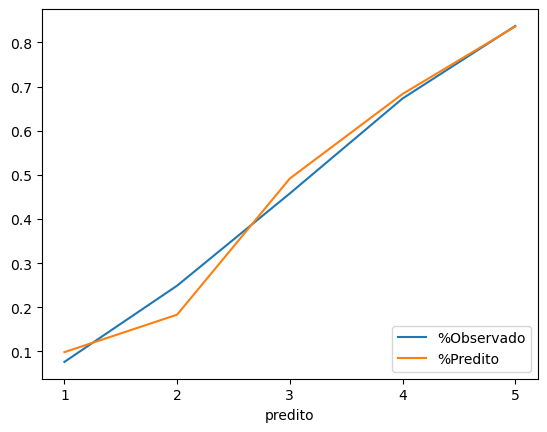

In [110]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid['predito'].plot(label='%Observado')
ax = qualid['pct_doente'].plot(label='%Predito')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc='lower right')

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [134]:
acc = metrics.accuracy_score(df['flag_doente'], df['predito'] > 5)
print('Acurácia = {0:.2f}%'.format(acc * 100))

Acurácia = 54.13%


In [144]:
ks = ks_2samp(df.loc[df['flag_doente']==1, 'predito'], df.loc[df['flag_doente']!=1, 'predito']).statistic
print('KS = {0:.2f}%'.format(ks * 100))

KS = 58.40%


In [146]:
fpr, tpr, threshold = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
gini = 2*auc_ - 1
print('GINI = {0:.2f}'.format(gini * 100))

GINI = 66.22


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [162]:
reglog = smf.logit('flag_doente ~ sex + cp + trestbps + restecg + thalach + exang + oldpeak', data=df).fit()
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.425750
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      295
Method:                           MLE   Df Model:                            7
Date:                Mon, 30 Sep 2024   Pseudo R-squ.:                  0.3827
Time:                        10:59:42   Log-Likelihood:                -129.00
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 3.243e-31
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.9002      1.838     -2.122      0.034      -7.502      -0.298
sex            1.6561      0.365      4.543      0.000       0.942       2.371
cp             0.8019      0.176      4.545      0.000       0.456       1.148
trestbps       0.0218      0.009      2.343      0.019       0.004       0.040
restecg        0.2863      0.157      1.822      0.068      -0.022       0.594
thalach       -0.0271      0.008     -3.382      0.001      -0.043      -0.011
exang          1.0024      0.355      2.828      0.005       0.308       1.697
oldpeak        0.6046      0.159      3.801      0.000       0.293       0.916
==============================================================================
"""